In [19]:
from pathlib import Path
import numpy as np
from datetime import datetime
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import pandas as pd
import glob

import cartopy.io.img_tiles as cimgt

from shapely.geometry.polygon import LinearRing


from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

import gdal
import cmocean
import cmaps

import seaborn as sns
from scipy.stats import norm, frechet_r, gumbel_r, weibull_min, weibull_max
import skextremes as ske

from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline

In [2]:
ds = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/Wind/CERSAT-GLO-BLENDED_WIND_L4_REP-V6-OBS_FULL_TIME_SERIE_1591368942032.nc')


<ipython-input-2-29d3eb14c5ed>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/Wind/CERSAT-GLO-BLENDED_WIND_L4_REP-V6-OBS_FULL_TIME_SERIE_1591368942032.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


In [12]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73.5, -73, -72.5, -72, -71.5, -71, -70.5, -70])
    gl.ylocator = mticker.FixedLocator([40, 40.5, 41, 41.5, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

Text(0.5, 1.0, '1992-01-14 06:00:00')

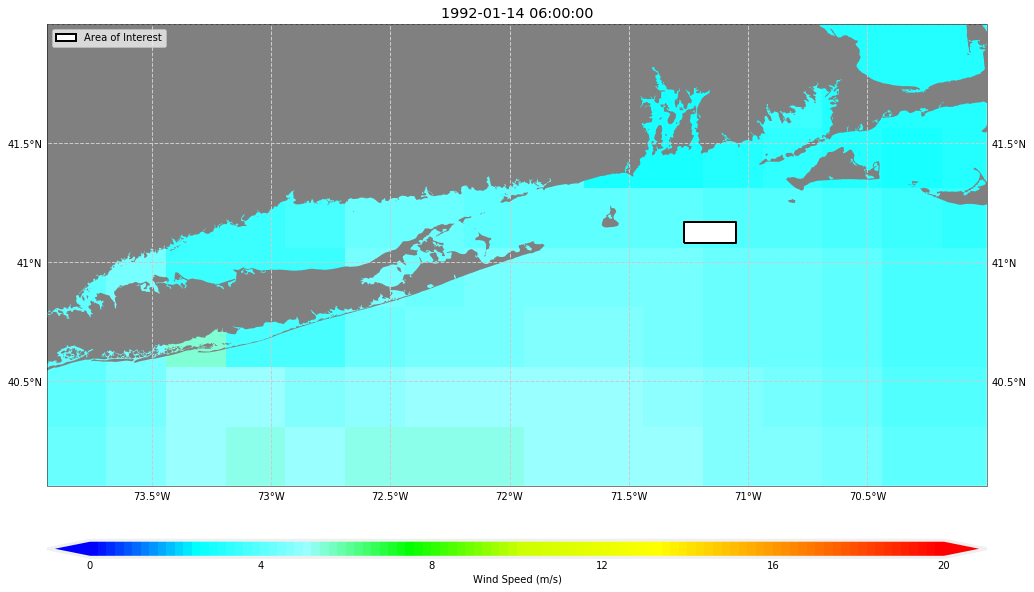

In [31]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-73.9375, -70, 40.0625, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,4,8,12,16,20])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cs2 = plt.pcolormesh(ds['lon'], ds['lat'], ds['wind_speed'][50], cmap=cmap, norm=norm,
            transform=ccrs.PlateCarree(), shading='flat', snap=True)
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=10)

lons = [-71.27, -71.27, -71.05, -71.05]
lats = [41.08, 41.17, 41.17, 41.08]
ring = LinearRing(list(zip(lons, lats)))
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='w', edgecolor='k', linewidth=2, label='Area of Interest')
LegendElement = [mpatches.Patch(facecolor='w', edgecolor='k', linewidth=2, label='Area of Interest')]

ax.legend(handles = LegendElement, loc='upper left')

ax.set_title('1992-01-14 06:00:00')
#plt.savefig('SNE_obs_SA_Level2_valid.png', dpi=300, bbox_inches='tight')

## Green Area: 1 0.2x0.2 deg Gridpoint (-71.1875W, 41.0625N)

Area of Interest:

Longitude : 71 16' W to 71 03' W  or  71.27 W to 71.05 W degress

Latitude : 41 05' N to 41 10' N   or  41.08 N to 41.17 N degrees

In [3]:
ds1 = ds[['wind_speed']]

ds2 = ds1.reset_index(dims_or_levels=['time','lon','lat'])

ds3 = ds2.to_dataframe()

ds4 = ds3[(ds3['lon_'] < -71.05) & (ds3['lon_'] > -71.25) & (ds3['lat_'] < 41.2) & (ds3['lat_'] > 41.05)]

ds5 = ds4.set_index('time_')

ds5

,wind_speed,lon_,lat_
time_,,,
1992-01-01 06:00:00,2.330078,-71.1875,41.0625
1992-01-01 12:00:00,3.269531,-71.1875,41.0625
1992-01-01 18:00:00,3.410156,-71.1875,41.0625
1992-01-02 00:00:00,0.830078,-71.1875,41.0625
1992-01-02 06:00:00,2.580078,-71.1875,41.0625
...,...,...,...
2018-12-30 18:00:00,3.900391,-71.1875,41.0625
2018-12-31 00:00:00,3.959961,-71.1875,41.0625
2018-12-31 06:00:00,2.360352,-71.1875,41.0625


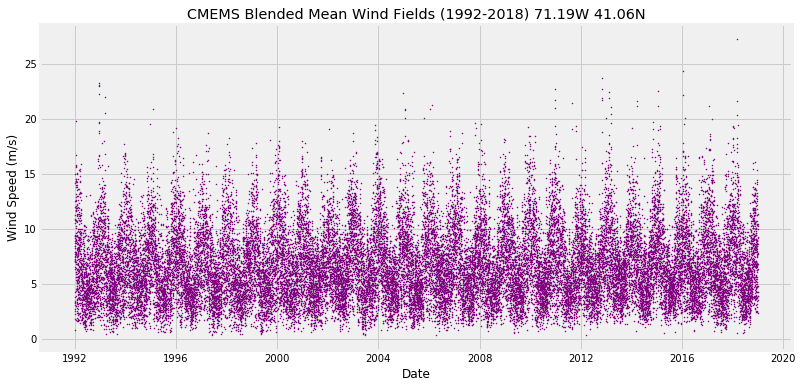

In [4]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(ds4['time_'],ds4['wind_speed'],s=1,color='purple')
#ax.scatter(b44097_wave['Date'],b44097_wave['WVHT'],s=1,color='purple')
ax.set(xlabel="Date",
       ylabel="Wind Speed (m/s)",
       title="CMEMS Blended Mean Wind Fields (1992-2018) 71.19W 41.06N")

plt.savefig('CMEMS_wind', dpi=300)

In [5]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    fig, ax = plt.subplots(figsize=(12,6))
    
    ax.scatter(series.index, series, s=1)
    #ax.plot(series.index, series, linewidth=2)
    ax.set(xlabel="Date", ylabel="Wind Speed (m/s)")
    
    
    # min_periods=2880 (month for half-hourly observations) for seasonality
    rolling_mean_ia = series.rolling(window=1440,center=True,min_periods=5).mean()

    #plt.title("Moving average\n window size = {}".format(window),fontsize=14)
    plt.plot(rolling_mean_ia, "k", label="12-Month Running Mean",linewidth=2)
    plt.tick_params(axis='both', labelsize=10)
    ax.set(xlabel="Date", ylabel="Wind Speed (m/s)")
    
    
    # min_periods=2880 (month for half-hourly observations) for seasonality
    rolling_mean_s = series.rolling(window=window,center=True,min_periods=5).mean()

    #plt.title("Moving average\n window size = {}".format(window),fontsize=14)
    plt.plot(rolling_mean_s, "r", label="3-Month Running Mean",linewidth=2)
    plt.tick_params(axis='both', labelsize=10)
    ax.set(xlabel="Date", ylabel="Wind Speed (m/s)")
    
    plt.legend(loc="best")
    plt.grid(True)

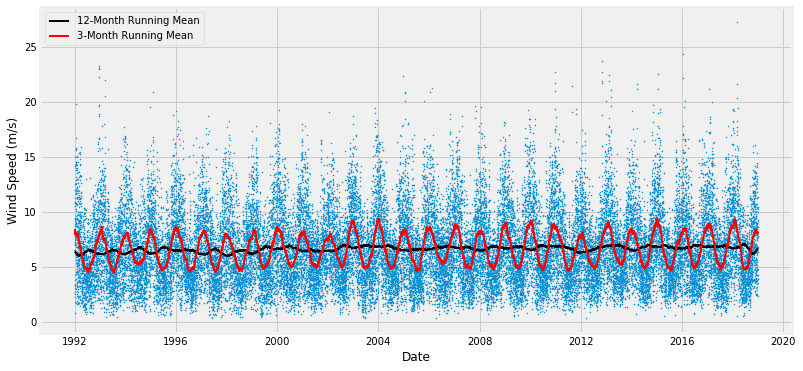

In [6]:
plotMovingAverage(ds5['wind_speed'], 360)

([<matplotlib.axis.XTick at 0x1b1b11cfa90>,
 <a list of 10 Text xticklabel objects>)

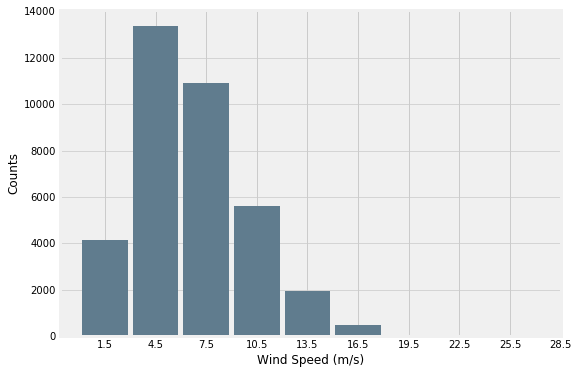

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
wind = ds5['wind_speed']
wind.plot.hist(grid=True, bins=[0,3,6,9,12,15,18,21,24,27], rwidth=0.9,
                   color='#607c8e')
#plt.title('')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

x=[1.5,4.5,7.5,10.5,13.5,16.5,19.5,22.5,25.5,28.5]
plt.xticks(x)

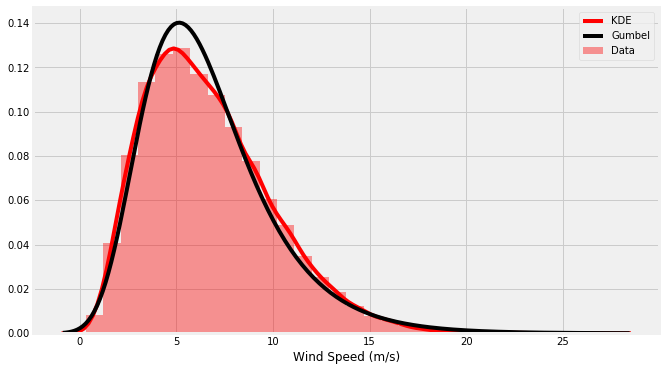

In [8]:
ws = pd.Series(ds5['wind_speed'], name="Wind Speed (m/s)")

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(ws, bins=30,fit=gumbel_r, hist_kws={"color": "r", "label": "Data"}, kde_kws={"color": "r", "label": "KDE"}, 
             fit_kws={"color": "k", "label": "Gumbel"})
ax.legend()

In [9]:
ws_ymean = ws.resample('Y').max()
len(ws_ymean)

27

In [10]:
ws_year = ws_ymean.to_numpy()

(<Figure size 1080x360 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x209890ec940>)

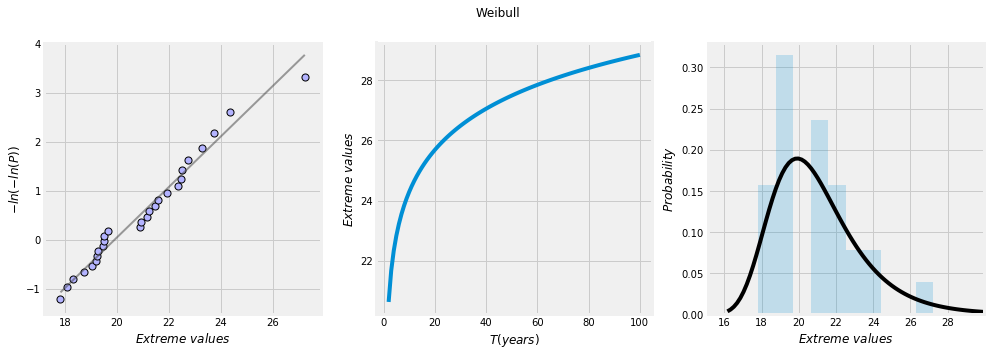

In [100]:
model = ske.models.engineering.PPPLiterature(data=ws_year, ppp='Weibull')

model.plot_summary()

Return Periods (Maximum Likelihood Estimation)

Fit data to a Gumbel distribution. Note that this is a special case of the GEV class where the shape is fixed to 0.

c:\users\panmits86\scikit-extremes\skextremes\models\classic.py:527: RuntimeWarning: divide by zero encountered in log
  sT = -_np.log(1.-self.frec/T)
c:\users\panmits86\scikit-extremes\skextremes\models\classic.py:527: RuntimeWarning: invalid value encountered in log
  sT = -_np.log(1.-self.frec/T)
c:\users\panmits86\scikit-extremes\skextremes\models\classic.py:506: RuntimeWarning: invalid value encountered in log
  return (len(x) * _np.log(scale) +
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\numdifftools\limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\numdifftools\limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) *

(<Figure size 576x432 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b1b564d8e0>)

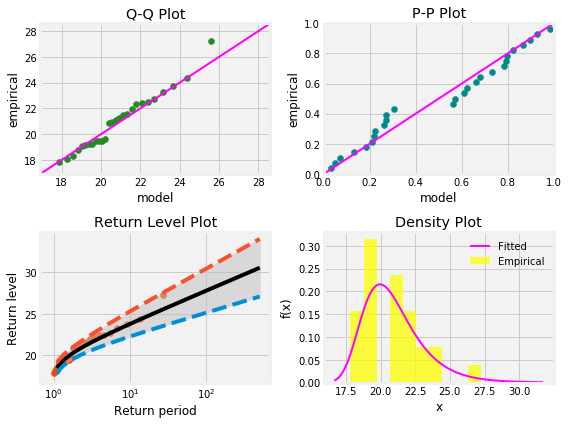

In [45]:
model = ske.models.classic.Gumbel(ws_year, fit_method='mle', ci=0.05, ci_method='delta', return_periods=50, frec=1)

model.plot_summary()

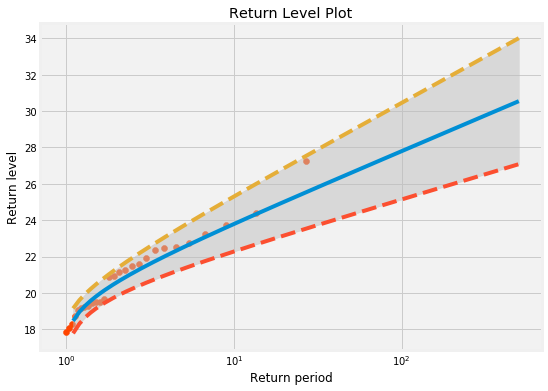

In [42]:
model.plot_return_values()

In [63]:
params = stats.exponweib.fit(ws, floc=0, f0=1)
shape = params[1]
scale = params[3]
print('shape:',shape)

shape: 2.1642924715746084
